# Assignment 2 For Clustering: Sessa Empirical Estimator
- Read the Journals about the Sessa Empirical Estimator.

- Convert the R codes into Python Codes (use jupyter notebook).

- Using Simulated data or a real world datasets of your choice, perform the Sessa Empircal Estimator and generate some insights.
    - https://www.frontiersin.org/journals/pharmacology/articles/10.3389/fphar.2019.00383/full
    - https://archive.ics.uci.edu/

- The Sessa Empirical Estimator uses K-Means clustering (again recall the disadvantages of K-Means), try to substitute a different clustering algorithm, generate a new insight using the new clustering algorithm.

- Compare your results between Sessa Empirical Estimator using K-Means, and Sessa Empirical Estimator using the clustering algorithm of your choice.

- Deadline is this Sunday, Feb 23, 2022 at 11:59 pm

- Do this with your thesis partner.

- You can use any A.I. assistant.

#### Import equivalent libraries from R to Python

In [ ]:
library(AdhereR)
library(dplyr)
library(plyr)
library(lubridate)
library(latticeExtra)
library(data.table)
library(factoextra)
library(stats)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from scipy.stats import norm
from sklearn import decomposition, preprocessing
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.stats import gaussian_kde
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer
from IPython.display import display

#### Convert and generate simulated data from article provided
- https://github.com/Masswear/BeyondThresholds/blob/master/Code/functions.R

- Asked GPT for the equivalent R functions in Python
    - i.e what in the world qnorm() is

In [3]:
np.random.seed(42)

def logistics(x, L=0, S=1, D=1, h=1, B=None): #used in groups 4 and 5
    if B is None:
        B = x - D
    y = (h-(5*L))/(1 + np.exp(S*B)) + L
    return y

def med_events_sample(ntot, start_date="01.01.2022", tot_duration=2*365, disp_durations=[30, 60, 90], dist_durations=[0.3, 0.5, 0.2], dist=[0.1, 0.2, 0.2, 0.2, 0.2, 0.1]):
    def offset(group, n): #gives back an array of offset dates based on the group number of assigned patient
        if group == 1:
            L, U, m, s = -0.1, 0.2, 0.05, 0.1
            pL, pU = norm.cdf(L, m, s), norm.cdf(U, m, s)
            offset = norm.ppf(np.random.uniform(pL, pU, n), m, s)
        elif group == 2:
            L, U, m, s = -0.2, 1.2, 0, 1
            pL, pU = norm.cdf(L, m, s), norm.cdf(U, m, s)
            offset = norm.ppf(np.random.uniform(pL, pU, n), m, s)
        elif group == 3:
            L, U, m, s = 0.5, 1.5, 1, 1
            pL, pU = norm.cdf(L, m, s), norm.cdf(U, m, s)
            offset1 = norm.ppf(np.random.uniform(pL, pU, n), m, s)
            t = 2/n * np.arange(1, n+1)
            offset = t* offset1
        elif group == 4:
            L, U, m, s = 0.8, 1.2, 1, 0.1
            pL, pU = norm.cdf(L, m, s), norm.cdf(U, m, s)
            offset1 = norm.ppf(np.random.uniform(pL, pU, n), m, s)
            offset = logistics(x=np.arange(1, n+1), L=0.05, S=10, D=n, B=np.sin(2*np.arange(1, n+1)-n))*offset1
        elif group == 5:
            L, U, m, s = 0.5, 1.5, 1, 1
            pL, pU = norm.cdf(L, m, s), norm.cdf(U, m, s)
            offset1 = norm.ppf(np.random.uniform(pL, pU, n), m, s)
            offset = logistics(x=np.arange(1, n+1), L=0.05, S=-15, D=n/3)*offset1
        elif group == 6:
            n =  np.random.choice([2,3])
            L, U, m, s = -0.2, 0.8, 0.3, 1
            pL, pU = norm.cdf(L, m, s), norm.cdf(U, m, s)
            offset = norm.ppf(np.random.uniform(pL, pU, n), m, s)

        return offset

    def refills(x, group): #fills all entries of refill dates for 1 patient 
        initial_fill = 30
        offsets = offset(group=group, n=len(disp_durations))

        durations = np.random.choice(disp_durations, size=len(offsets)-1, replace=True, p=dist_durations)
        durations = np.insert(durations, 0, initial_fill)

        date = datetime.strptime(start_date, "%d.%m.%Y").date()

        refill_dates = [date] + [date + timedelta(days=int(sum(durations[:i+1]) + round(offsets[i] * durations[i], 0))) for i in range(len(durations))] #might be the cause of only 3 refill dates every patient

        medicine_type = np.random.choice(['Med_A', 'Med_B', 'Med_C'])

        df = pd.DataFrame({
            'GROUP': group,
            'PATIENT_ID': x, 
            'DATE': refill_dates[:-1],
            'DURATION': durations,
            'ATC' : medicine_type
        })
        

        return df

    ID_last = 0
    sample = pd.DataFrame()
    
    mean_duration = np.sum(np.array(disp_durations) * np.array(dist_durations))

    n = int(np.ceil((tot_duration/mean_duration) * 1.5))

    temp_samples = []

    for i in range(1, 6):
        num_pat = round(dist[i-1] * ntot) #this evenly spaces out the patients sequentially to each group, i think this should be changed to random
        ID_first = ID_last + 1
        ID_last = ID_first + num_pat - 1
        temp_groups = [refills(x, i) for x in range(ID_first, ID_last + 1)]
        temp_groups = [g for g in temp_groups if not g.empty]  # Remove empty DataFrames

        if temp_groups:
            group = pd.concat(temp_groups)
            temp_samples.append(group)

    num_pat = ntot - ID_last
    ID_first = ID_last + 1
    ID_last = ID_first + num_pat - 1
    temp_groups = [refills(x, 6) for x in range(ID_first, ID_last + 1)] #meant to assign any leftovers to group6
    temp_groups = [g for g in temp_groups if not g.empty] 

    if temp_groups: 
        group = pd.concat(temp_groups) 
        temp_samples.append(group)
        sample.reset_index(drop=True, inplace=True)
        
    if temp_samples:
        sample = pd.concat(temp_samples)
        sample.reset_index(drop=True, inplace=True)

    if sample.empty:
        print("No data was generated!")
    else:
        display(sample)
        # sample.to_csv("med_events_sample.csv", index=False)
        # print("CSV file saved: med_events_sample.csv")

if __name__ == "__main__":
    ntot = 100  # Example number of patients
    med_events_sample(ntot)

,GROUP,PATIENT_ID,DATE,DURATION,ATC
0,1,1,2022-01-01,30,Med_C
1,1,1,2022-02-01,60,Med_C
2,1,1,2022-04-11,30,Med_C
3,1,2,2022-01-01,30,Med_A
4,1,2,2022-01-29,30,Med_A
...,...,...,...,...,...
291,6,98,2022-05-17,60,Med_C
292,6,99,2022-01-01,30,Med_C
293,6,99,2022-02-07,60,Med_C
294,6,100,2022-01-01,30,Med_B


### Converting the Sessa Empirical Estimation from R to Python
- See the SEE.R file found in the same directory

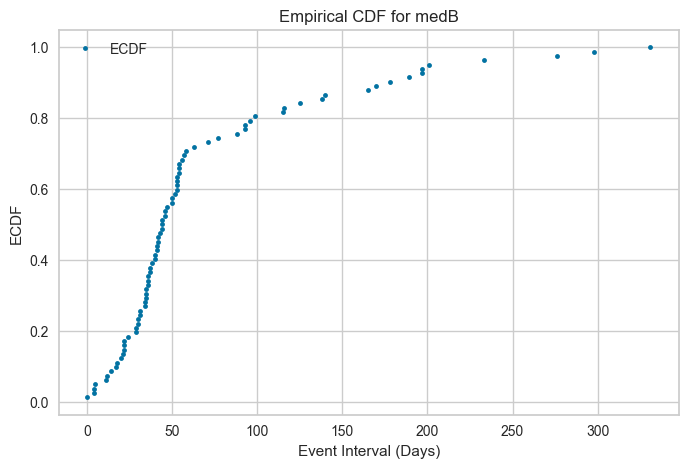

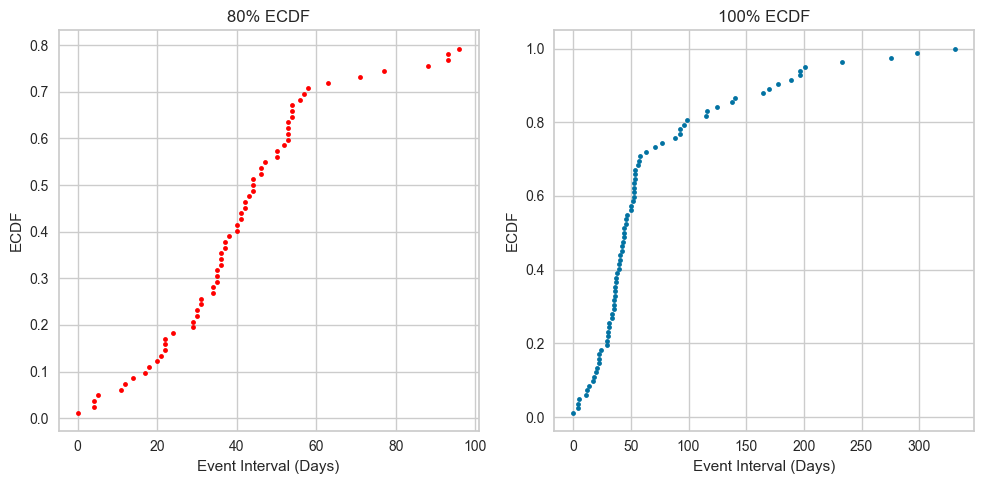

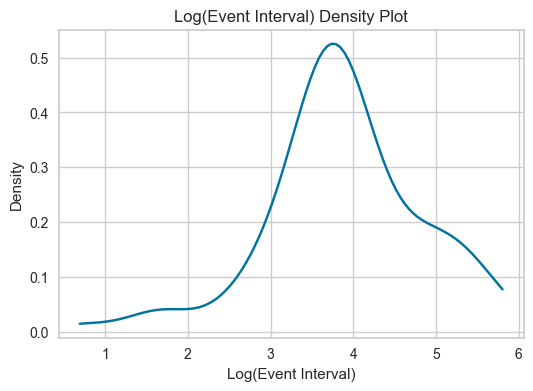

Optimal number of clusters: 3, Silhouette Score: 0.6396


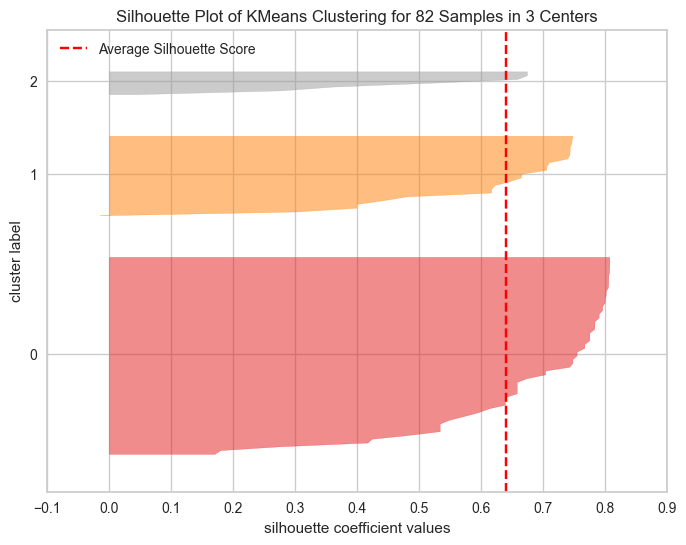

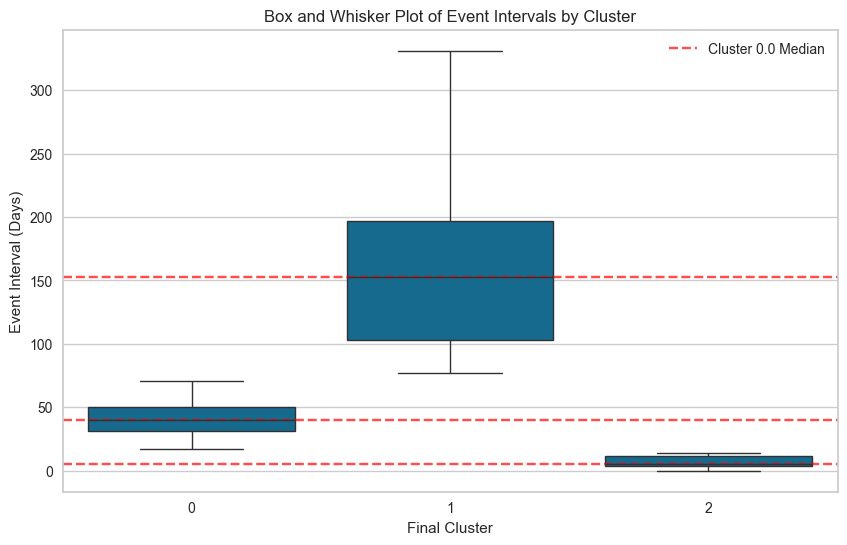

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.stats import gaussian_kde
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer
from statsmodels.distributions.empirical_distribution import ECDF
import seaborn as sns

# Step 1: Load and preprocess data
def load_and_preprocess_data(filepath, med_type):
    # Load the dataset
    df = pd.read_csv(filepath)
    
    # Convert DATE column to datetime
    df["DATE"] = pd.to_datetime(df["DATE"])
    
    # Filter data for the specified medication type
    df_filtered = df[df["CATEGORY"] == med_type].copy()
    
    # Sort by PATIENT_ID and DATE
    df_filtered = df_filtered.sort_values(by=["PATIENT_ID", "DATE"])
    
    # Compute previous visit date for each patient
    df_filtered["PREV_DATE"] = df_filtered.groupby("PATIENT_ID")["DATE"].shift(1)
    
    # Drop rows where PREV_DATE is NaN (first visit for each patient)
    df_filtered = df_filtered.dropna(subset=["PREV_DATE"])
    
    # Compute event interval in days
    df_filtered["EVENT_INTERVAL"] = (df_filtered["DATE"] - df_filtered["PREV_DATE"]).dt.days
    
    # Sample one refill interval per patient
    df_sampled = df_filtered.groupby("PATIENT_ID").sample(n=1, random_state=42)
    
    return df_sampled

# Step 2: Visualize ECDF and remove extreme intervals
def plot_ecdf(df_sampled, med_type):
    # Compute ECDF
    ecdf = ECDF(df_sampled["EVENT_INTERVAL"])
    df_ecdf = pd.DataFrame({"x": ecdf.x, "y": ecdf.y})
    
    # Plot ECDF
    plt.figure(figsize=(8, 5))
    plt.plot(df_ecdf["x"], df_ecdf["y"], marker=".", linestyle="none", label="ECDF")
    plt.xlabel("Event Interval (Days)")
    plt.ylabel("ECDF")
    plt.title(f"Empirical CDF for {med_type}")
    plt.legend()
    plt.show()
    
    # Retain 80% of the ECDF
    df_ecdf_80 = df_ecdf[df_ecdf["y"] <= 0.8]
    ni = df_ecdf["x"].max()
    
    # Plot 80% and 100% ECDF
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(df_ecdf_80["x"], df_ecdf_80["y"], marker=".", linestyle="none", color="red")
    plt.xlabel("Event Interval (Days)")
    plt.ylabel("ECDF")
    plt.title("80% ECDF")
    
    plt.subplot(1, 2, 2)
    plt.plot(df_ecdf["x"], df_ecdf["y"], marker=".", linestyle="none")
    plt.xlabel("Event Interval (Days)")
    plt.ylabel("ECDF")
    plt.title("100% ECDF")
    
    plt.tight_layout()
    plt.show()
    
    return df_ecdf_80, ni

# Step 3: Log-transform intervals and estimate density
def plot_density(df_filtered, ni):
    # Filter out extreme intervals
    df_filtered = df_filtered[df_filtered["EVENT_INTERVAL"] <= ni]
    
    # Replace 0 with 1 to avoid log(0)
    df_filtered["EVENT_INTERVAL"] = df_filtered["EVENT_INTERVAL"].replace(0, 1)
    
    # Log-transform intervals
    log_intervals = np.log1p(df_filtered["EVENT_INTERVAL"])
    
    # Estimate density using Gaussian KDE
    density = gaussian_kde(log_intervals)
    x_vals = np.linspace(log_intervals.min(), log_intervals.max(), 100)
    y_vals = density(x_vals)
    
    # Plot density
    plt.figure(figsize=(6, 4))
    plt.plot(x_vals, y_vals)
    plt.xlabel("Log(Event Interval)")
    plt.ylabel("Density")
    plt.title("Log(Event Interval) Density Plot")
    plt.show()
    
    return log_intervals

# Step 4: Find optimal number of clusters
def find_optimal_clusters(log_intervals):
    # Convert Series to NumPy array and reshape for clustering
    X = log_intervals.to_numpy().reshape(-1, 1)
    
    # Find best K using silhouette score
    best_k = None
    best_score = -1
    cluster_range = range(2, 10)
    
    for k in cluster_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(X)
        score = silhouette_score(X, labels)
        
        if score > best_score:
            best_k = k
            best_score = score
    
    print(f"Optimal number of clusters: {best_k}, Silhouette Score: {best_score:.4f}")
    
    # Visualize silhouette plot
    fig, ax = plt.subplots(figsize=(8, 6))
    kmeans = KMeans(n_clusters=best_k, random_state=42)
    visualizer = SilhouetteVisualizer(kmeans, ax=ax)
    visualizer.fit(X)
    visualizer.show()
    
    return best_k

# Step 5: Assign patients to clusters
def assign_clusters(df_filtered, log_intervals, best_k):
    # Convert Series to NumPy array and reshape for clustering
    X = log_intervals.to_numpy().reshape(-1, 1)
    
    # Fit KMeans
    kmeans = KMeans(n_clusters=best_k, random_state=42)
    clusters = kmeans.fit_predict(X)
    
    # Add cluster labels to the original DataFrame
    df_filtered["Final_Cluster"] = clusters
    
    return df_filtered

def assign_median_duration(final_df):
    median_refill = final_df.groupby('Final_Cluster')['EVENT_INTERVAL'].median().reset_index()
    median_refill.columns = ['Final_Cluster', 'Median_Refill_Interval']
    final_df = final_df.merge(median_refill, on='Final_Cluster', how='left')
    return final_df

  
def box_and_whisker_plot(final_df):
    plt.figure(figsize=(10, 6))
    
    # Boxplot of Event Interval 
    sns.boxplot(x="Final_Cluster", y="EVENT_INTERVAL", data=final_df, showfliers=True)
    
    # Overlay median refill intervals per cluster
    median_intervals = final_df.groupby("Final_Cluster")[["Median_Refill_Interval"]].first().reset_index()
    for index, row in median_intervals.iterrows():
        plt.axhline(y=row["Median_Refill_Interval"], color="red", linestyle="--", alpha=0.7, label=f"Cluster {row['Final_Cluster']} Median" if index == 0 else "")
    
    # Labels and title
    plt.xlabel("Final Cluster")
    plt.ylabel("Event Interval (Days)")
    plt.title("Box and Whisker Plot of Event Intervals by Cluster")
    plt.legend()
    plt.show()

# Main function
def main():
    # Filepath and medication type
    filepath = "med_events.csv"
    med_type = "medB"
    
    # Step 1: Load and preprocess data
    df_sampled = load_and_preprocess_data(filepath, med_type)
    
    # Step 2: Visualize ECDF and remove extreme intervals
    df_ecdf_80, ni = plot_ecdf(df_sampled, med_type)
    
    # Step 3: Log-transform intervals and estimate density
    log_intervals = plot_density(df_sampled, ni)
    
    # Step 4: Find optimal number of clusters
    best_k = find_optimal_clusters(log_intervals)
    
    # Step 5: Assign patients to clusters
    
    df_filtered = assign_clusters(df_sampled, log_intervals, best_k)
    
    #Step 6: Find median interval (duration) for each cluster
    df_filtered = assign_median_duration(df_filtered)

    #Step 8: box and whisker plot
    box_and_whisker_plot(df_filtered)

    # Step 7: Return final dataset
    final_df = df_filtered[["PATIENT_ID", "EVENT_INTERVAL", "Final_Cluster", "Median_Refill_Interval"]]
    return final_df

 
    
# Run the main function
if __name__ == "__main__":
    final_df = main()
    final_df.to_csv("clustersandduration.csv", index=False)